# Практическая работа 8

Вариант 2 (16 % 7)

Полностью копируем практическую работу №6 и добавляем свой CallBack

Вариант 2 Построение и сохранение карты признаков на заданных пользователем эпохах. Карта признаков - ядро свертки представленное в виде изображения. Название карты признака должно иметь вид <номер слоя><номер ядра в слое><номер эпохи>

Файл 1

In [229]:
import numpy as np
import matplotlib.pyplot as plt

In [230]:
def gen_circle(size=50):
    img = np.zeros([size, size])
    x = np.random.randint(0, size)
    y = np.random.randint(0, size)
    r = np.random.randint(size // 10, size // 3)
    for i in range(0, size):
        for j in range(0, size):
            if (i-x)**2 + (j-y)**2 <= r**2:
                img[i, j] = 1
    return img


def gen_empty_circle(size=50):
    img = np.zeros([size, size])
    x = np.random.randint(0, size)
    y = np.random.randint(0, size)
    r = np.random.randint(size // 10, size // 3)
    dr = np.random.randint(1, 10) + r
    for i in range(0, size):
        for j in range(0, size):
            if r**2 <= (i - x) ** 2 + (j - y) ** 2 <= dr ** 2:
                img[i, j] = 1
    return img

Файл 2

In [231]:
def gen_data(size=500, img_size=50):
    c1 = size // 2
    c2 = size - c1
    label_c1 = np.full([c1, 1], 'Empty')
    data_c1 = np.array([gen_empty_circle(img_size) for i in range(c1)])
    label_c2 = np.full([c2, 1], 'Not Empty')
    data_c2 = np.array([gen_circle(img_size) for i in range(c2)])
    data = np.vstack((data_c1, data_c2))
    label = np.vstack((label_c1, label_c2))
    return data, label

Выводим данные для проверки корректности генерации

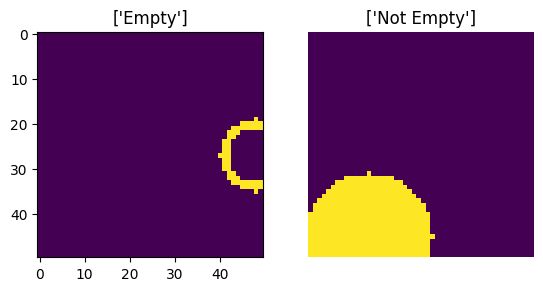

In [232]:
data, labels = gen_data()
# print(data, labels)

plt.subplot(121)
plt.imshow(data[0])
plt.title(labels[0])
plt.subplot(122)
plt.imshow(data[-1])
plt.title(labels[-1])
plt.axis("off")
plt.show()

Перемешивание данных

In [233]:
indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Нормализируем

In [234]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels.ravel())

Разделяем выборку

In [235]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5)

Проверяем, что все разделилось ровно

In [236]:
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Validation class distribution: {np.bincount(y_val)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Train class distribution: [181 169]
Validation class distribution: [33 42]
Test class distribution: [36 39]


In [237]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback
import os

Создаем Callback для сохранения карт признаков сверточных слоев

In [238]:
def create_map(epoch, logs, model, output_dir, interval):
    if (epoch + 1) % interval == 0 or epoch == 0:
        print(f"\nСоздаем карту признаков на {epoch + 1} эпохе...\n")
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for layer_index, layer in enumerate(model.layers):
            if isinstance(layer, layers.Conv2D):
                weights, biases = layer.get_weights()
                num_of_kernel = weights.shape[-1]

                normalized_weights = (
                    weights - weights.min()) / (weights.max() - weights.min()
                                                )

                for kernel_index in range(num_of_kernel):
                    kernel_weights = normalized_weights[:, :, :, kernel_index]

                    # Усреднение по каналам, если их больше одного
                    if kernel_weights.shape[-1] > 1:
                        kernel_weights = np.mean(kernel_weights, axis=-1)

                    plt.imshow(kernel_weights, cmap='grey')
                    plt.axis('off')
                    filename = f"{layer_index}_{kernel_index - (layer_index)}_{epoch + 1}.png"
                    plt.savefig(os.path.join(output_dir, filename))
                    plt.close()


kernel_map_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: create_map(
        epoch, logs, model, output_dir="maps", interval=5
    )
)

Создаем архитектуру сверточной нейронной сети

In [239]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(
        50, 50, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [240]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 11, 11, 64)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 9, 9, 64)        

In [241]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Добавляем Callback с ранней остановкой

In [242]:
early_stopping = EarlyStopping(
    monitor='val_loss', min_delta=0.0005, patience=5, restore_best_weights=True)

In [243]:
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(x_val, y_val), callbacks=[early_stopping, kernel_map_callback], shuffle=True)

Epoch 1/100


2024-12-23 04:29:42.149962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-23 04:29:42.307674: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


11/11 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5629

2024-12-23 04:29:44.110293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Создаем карту признаков на 1 эпохе...

11/11 [==============================] - 13s 1s/step - loss: 0.6930 - accuracy: 0.5629 - val_loss: 0.6621 - val_accuracy: 0.6800
Epoch 2/100
11/11 [==============================] - 0s 33ms/step - loss: 0.6391 - accuracy: 0.6229 - val_loss: 0.6152 - val_accuracy: 0.7467
Epoch 3/100
11/11 [==============================] - 0s 33ms/step - loss: 0.5539 - accuracy: 0.7343 - val_loss: 0.4572 - val_accuracy: 0.8000
Epoch 4/100
11/11 [==============================] - 0s 35ms/step - loss: 0.4309 - accuracy: 0.7771 - val_loss: 0.3090 - val_accuracy: 0.8533
Epoch 5/100
11/11 [==============================] - ETA: 0s - loss: 0.4106 - accuracy: 0.8086
Создаем карту признаков на 5 эпохе...

11/11 [==============================] - 8s 814ms/step - loss: 0.4106 - accuracy: 0.8086 - val_loss: 0.2808 - val_accuracy: 0.8933
Epoch 6/100
11/11 [==============================] - 0s 35ms/step - loss: 0.2696 - accuracy: 0.8971 - val_loss: 0.2350 - val_accuracy: 0.933

Выводим точность

In [244]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

3/3 - 0s - loss: 0.1929 - accuracy: 0.9333 - 59ms/epoch - 20ms/step
Test accuracy: 0.9333333373069763


Визулизируем и проверяем предсказания

1/1 [==============================] - 0s 171ms/step


2024-12-23 04:30:22.925917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


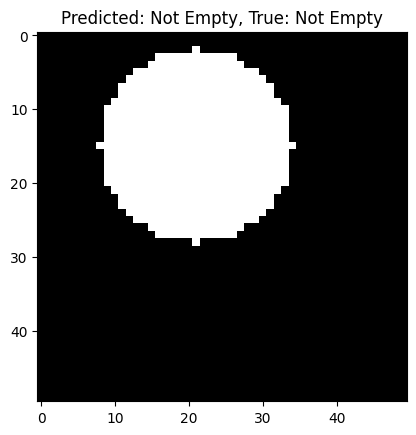

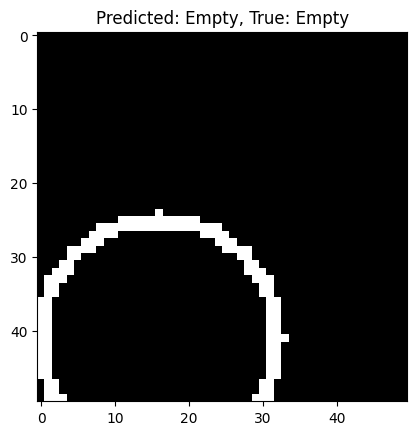

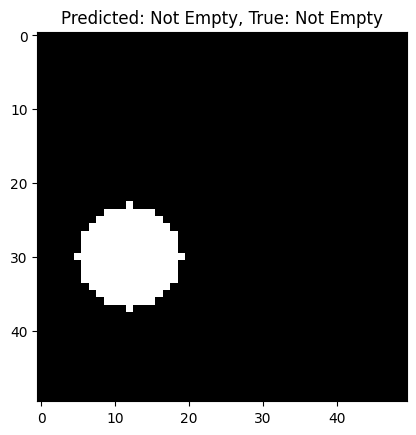

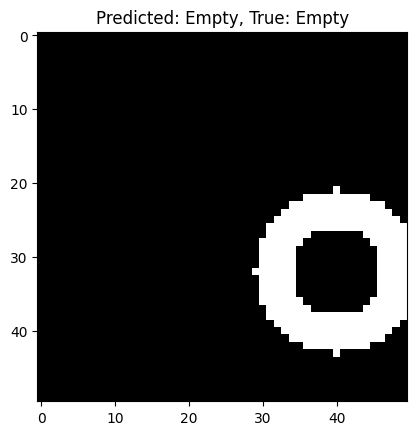

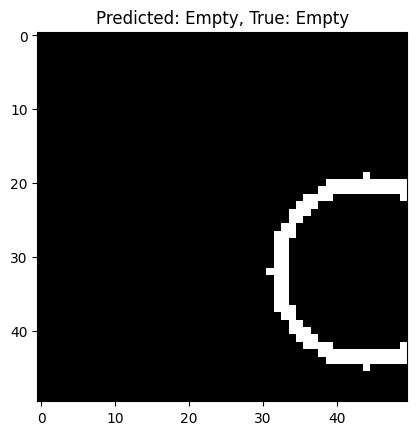

In [245]:
import matplotlib.pyplot as plt

predictions = model.predict(x_test[:5]).flatten()

for i, pred in enumerate(predictions):
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    predicted_label = 'Not Empty' if pred > 0.5 else 'Empty'
    true_label = 'Not Empty' if y_test[i] else 'Empty'
    plt.title(f"Predicted: {predicted_label}, True: {true_label}")
    plt.show()

Выводим график потерь и точности

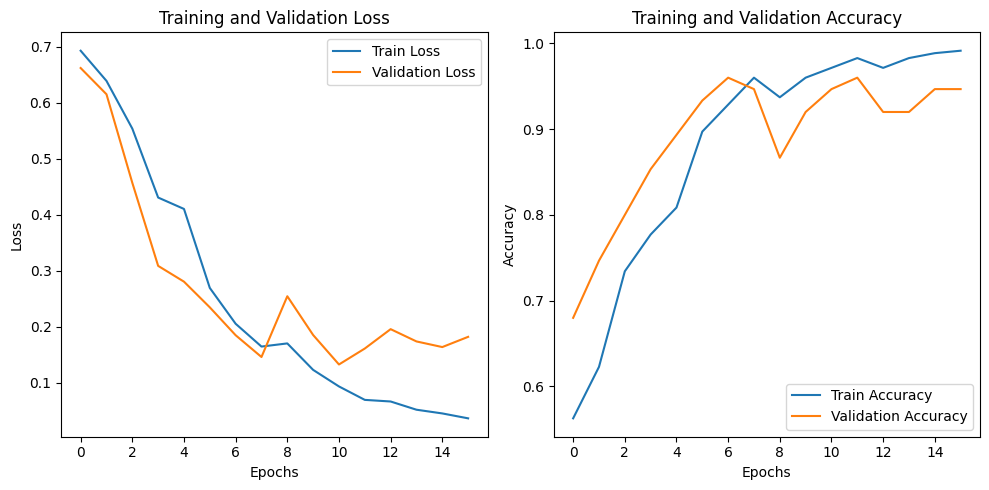

In [246]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()